__Author__: Ryan Tang Li Jian

# Problem Framing

Churn Definition
- A member is considered churned if they haven’t made any transactions in the last 90 days from the point of analysis.

Prediction Goal
- Our main objective is to predict the probability that a currently active member will churn in the next 3 months.
- This forward-looking view allows us to proactively identify and engage at-risk users before they drop off.

Evaluation Strategy
- To ensure that our model performs well not just technically but also from a business lens, we’ll evaluate it in three layers:
    - Primary Metric: AUC-ROC
        - This helps us understand how well the model distinguishes between users who will churn vs those who won’t.
        - AUC-ROC is useful because it gives a balanced view of performance across all classification thresholds.
    - Secondary Metric: Precision-Recall Curve
        - Since churn data is often imbalanced (more non-churned than churned, well dependds on the business), this curve helps us assess how precise the model is when it predicts churn, and how many of the actual churned users it captures.
    - Business Metric: Precision at Top 20%
        - From a campaign or retention perspective, we care most about the top segment of users most at risk.
        - Precision@20% shows us, out of the 20% most at-risk users (based on predicted scores), how many truly churned.
        - This is especially useful for prioritising interventions, like targeted retention emails or loyalty offers.

it's 2 am in the morning so i just focusedo n the AUC

# Environment Setup

In [196]:
import sys
import os
from pathlib import Path
"""
The code within '/scripts' have been used across multiple personal projects that I have written so it may 
include functions or configurations that are not applicable in this case, but they just make it easier for me to set things up （￣︶￣）↗
"""

# Problem Statement: Get the path to the 'scripts' directory, due to the structure of the folders, we will need to import the path, so 
# that the jupyter notebook can find the corresponding directory, if this extends, should create a packages instead to be installed
code_path = os.path.abspath('../scripts')
if code_path not in sys.path:
    sys.path.insert(0, code_path)

In [197]:
# Install the environment file to run this
conda env create -f ../environment.yml
conda activate bonuslink

SyntaxError: invalid syntax (1343212442.py, line 2)

Most of my analysis will be done in Polars, as it's my preferred tool for quick data exploration—especially when working with relatively larger datasets. It offers key advantages like multithreaded processing and a cleaner, more concise syntax, which make it easier for me to perform my analysis. (●'◡'●)

Any extra needed visualisation and etc will be done in pandas instead due to its vast incoporation with other pacakges.

In [ ]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pendulum
from polars_parquet_reader import PolarsParquetReader
from file_system import FileSystem

In [218]:
main_path = Path(os.getcwd())
checkpoint_data_path = main_path.parent.joinpath("data", "checkpoint")
train_data_path = main_path.parent.joinpath("data", "train")

In [219]:
pl.Config(tbl_cols=-1, tbl_rows=-1)

In [220]:
pr = PolarsParquetReader()
fs = FileSystem()

In [221]:
members_df = pl.read_csv("../data/members.csv").lazy() \
    .with_columns(
        pl.col("signup_date").str.to_date().alias("signup_date")
    )
merchants_df = pl.read_csv("../data/merchants.csv").lazy() \
    .with_columns(
        pl.col("join_date").str.to_date().alias("join_date")
    )
transactions_df = pl.read_csv("../data/transactions.csv").lazy() \
    .with_columns(
        pl.col("timestamp").str.to_date().alias("timestamp")
    )
engagement_df = pl.read_csv("../data/engagement.csv").lazy()

Just Performing a Quick Exploration of the Dataset

In [222]:
print(f"members_df: {members_df.collect().shape}")
print(f"merchants_df: {merchants_df.collect().shape}")
print(f"transactions_df: {transactions_df.collect().shape}")
print(f"engagement_df: {engagement_df.collect().shape}")

members_df: (500, 5)
merchants_df: (20, 5)
transactions_df: (3000, 5)
engagement_df: (500, 4)


In [223]:
members_df.collect().head(5)

member_id,signup_date,tier,age_group,state
str,date,str,str,str
"""M0001""",2022-04-13,"""Gold""","""55+""","""Sabah"""
"""M0002""",2022-12-15,"""Silver""","""18-24""","""Penang"""
"""M0003""",2022-09-28,"""Silver""","""55+""","""Kuala Lumpur"""
"""M0004""",2022-04-17,"""Platinum""","""55+""","""Johor"""
"""M0005""",2022-03-13,"""Silver""","""35-44""","""Penang"""


In [224]:
members_df.group_by("tier").len().sort("len", descending=True).collect().head()

tier,len
str,u32
"""Silver""",303
"""Gold""",138
"""Platinum""",59


In [225]:
members_df.null_count().collect() # check for nulls

member_id,signup_date,tier,age_group,state
u32,u32,u32,u32,u32
0,0,0,0,0


In [226]:
members_df \
    .select(
        pl.min("signup_date").alias("min_date"),
        pl.max("signup_date").alias("max_date")
    ) \
    .collect() \
    .head()

min_date,max_date
date,date
2022-01-01,2022-12-31


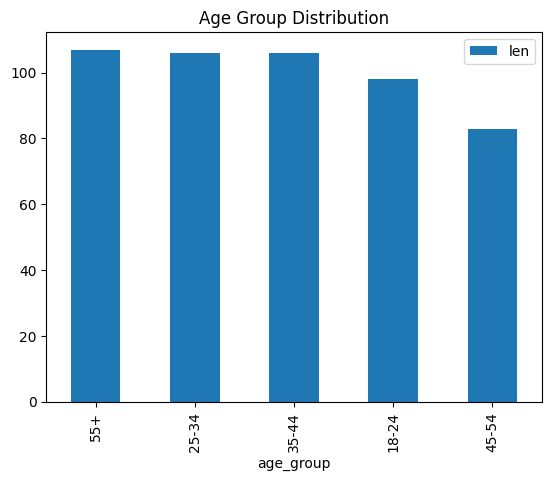

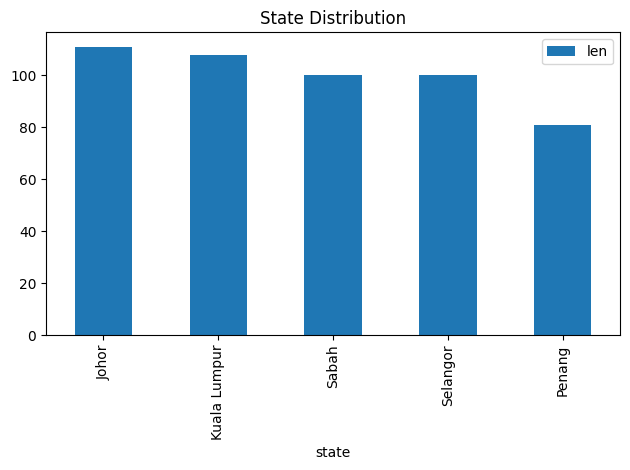

In [227]:
members_df \
    .group_by(
        "age_group"
    ) \
    .len() \
    .sort("len", descending=True) \
    .collect() \
    .to_pandas() \
    .plot(kind="bar", title="Age Group Distribution", x="age_group", y="len")

members_df \
    .group_by(
        "state"
    ) \
    .len() \
    .sort("len", descending=True) \
    .collect() \
    .to_pandas() \
    .plot(kind="bar", title="State Distribution", x="state", y="len")
plt.tight_layout()

In [228]:
merchants_df.collect().head(5)

merchant_id,merchant_name,category,location,join_date
str,str,str,str,date
"""MER001""","""Merchant_1""","""eCommerce""","""Penang""",2022-04-11
"""MER002""","""Merchant_2""","""eCommerce""","""PJ""",2021-11-07
"""MER003""","""Merchant_3""","""eCommerce""","""KK""",2021-09-19
"""MER004""","""Merchant_4""","""eCommerce""","""Penang""",2022-02-23
"""MER005""","""Merchant_5""","""Retail""","""KL""",2022-02-10


In [229]:
merchants_df.null_count().collect() # check for nulls

merchant_id,merchant_name,category,location,join_date
u32,u32,u32,u32,u32
0,0,0,0,0


In [230]:
transactions_df.collect().head(5)

transaction_id,member_id,merchant_id,spend_amount,timestamp
str,str,str,f64,date
"""T00001""","""M0076""","""MER010""",9.76,2023-06-07
"""T00002""","""M0385""","""MER010""",5.81,2023-05-14
"""T00003""","""M0439""","""MER020""",41.85,2023-03-08
"""T00004""","""M0278""","""MER009""",131.79,2023-12-02
"""T00005""","""M0040""","""MER017""",2.82,2023-01-07


In [231]:
transactions_df \
    .select(
        pl.min("timestamp").alias("min_date"),
        pl.max("timestamp").alias("max_date")
    ) \
    .collect() \
    .head()

min_date,max_date
date,date
2023-01-01,2023-12-31


In [232]:
transactions_df.null_count().collect() # check for nulls

transaction_id,member_id,merchant_id,spend_amount,timestamp
u32,u32,u32,u32,u32
0,0,0,0,0


In [233]:
engagement_df.collect().head(5)

member_id,monthly_logins,redemptions,app_opens
str,i64,i64,i64
"""M0001""",4,1,10
"""M0002""",4,1,7
"""M0003""",6,2,11
"""M0004""",3,1,16
"""M0005""",3,1,7


In [234]:
engagement_df.null_count().collect() # check for nulls

member_id,monthly_logins,redemptions,app_opens
u32,u32,u32,u32
0,0,0,0


# Feature Engineering

In [235]:
# Join the data points tgt
master_df = transactions_df \
    .join(
        members_df,
        on = "member_id"
    ) \
    .join( # TODO: Don't think this is any useful
        merchants_df,
        on = "merchant_id"
    )

Adjust the dates accordingly to when we are analysing

In [236]:
analysis_date = pendulum.parse("2023-12-31")
churn_threshold_date = analysis_date.subtract(days=90) # 3 months ago

In [237]:
print(analysis_date.to_date_string())
print(churn_threshold_date.to_date_string())

2023-12-31
2023-10-02


In [238]:
transaction_features = transactions_df \
    .with_columns([
        (pl.lit(analysis_date.to_date_string()).str.to_date() - pl.col("timestamp")).dt.total_days().alias("days_since_transaction")
    ]) \
    .group_by(
        "member_id"
    ) \
    .agg([
            # Recency features
            pl.col("days_since_transaction").min().alias("days_since_last_transaction"),
            pl.col("days_since_transaction").max().alias("days_since_first_transaction"),
            
            # Frequency features
            pl.col("transaction_id").count().alias("total_transactions"),
            pl.col("timestamp").n_unique().alias("unique_transaction_days"),
            
            # Monetary features
            pl.col("spend_amount").sum().alias("total_spend"),
            pl.col("spend_amount").mean().alias("avg_spend_per_transaction"),
            pl.col("spend_amount").std().alias("spend_std"),
            pl.col("spend_amount").max().alias("max_spend"),
            pl.col("spend_amount").min().alias("min_spend"),
            
            # Behavioral patterns that users exhibited -> potentially more merchants higher likelihood of staying
            pl.col("merchant_id").n_unique().alias("unique_merchants"),
            
            # Check Recent activity (last 30 days)
            pl.col("spend_amount").filter(pl.col("days_since_transaction") <= 30).sum().alias("spend_last_30d"),
            pl.col("transaction_id").filter(pl.col("days_since_transaction") <= 30).count().alias("transactions_last_30d"),
        ]
    )   


In [239]:
transaction_features.collect().head()

member_id,days_since_last_transaction,days_since_first_transaction,total_transactions,unique_transaction_days,total_spend,avg_spend_per_transaction,spend_std,max_spend,min_spend,unique_merchants,spend_last_30d,transactions_last_30d
str,i64,i64,u32,u32,f64,f64,f64,f64,f64,u32,f64,u32
"""M0035""",24,357,8,8,250.6,31.325,24.074449,66.74,0.1,7,66.74,1
"""M0454""",19,216,4,4,355.92,88.98,70.030286,189.54,39.21,4,43.17,1
"""M0236""",2,343,8,8,455.88,56.985,60.386811,146.91,1.71,5,236.13,2
"""M0100""",42,210,5,5,336.89,67.378,122.490188,285.28,1.04,3,0.0,0
"""M0136""",323,360,2,2,102.67,51.335,35.546258,76.47,26.2,2,0.0,0


In [240]:
member_features = members_df.with_columns([
    (pl.lit(analysis_date.to_date_string()).str.to_date() - pl.col("signup_date")).dt.total_days().alias("end_to_start_days"),
    pl.col("tier").map_elements(
        lambda x: {"Silver": 1, "Gold": 2, "Platinum": 3}.get(x, 1), 
        return_dtype=pl.Int32
    ).alias("tier_numeric")
    # Mapy it to numeric to make better for processing
])

In [241]:
member_features.collect().head()

member_id,signup_date,tier,age_group,state,end_to_start_days,tier_numeric
str,date,str,str,str,i64,i32
"""M0001""",2022-04-13,"""Gold""","""55+""","""Sabah""",627,2
"""M0002""",2022-12-15,"""Silver""","""18-24""","""Penang""",381,1
"""M0003""",2022-09-28,"""Silver""","""55+""","""Kuala Lumpur""",459,1
"""M0004""",2022-04-17,"""Platinum""","""55+""","""Johor""",623,3
"""M0005""",2022-03-13,"""Silver""","""35-44""","""Penang""",658,1


In [242]:
engagement_features = engagement_df.with_columns([
        (pl.col("monthly_logins") + pl.col("redemptions") + pl.col("app_opens")).alias("total_engagement"),
        (pl.col("redemptions") / pl.col("monthly_logins").clip(1)).alias("redemption_rate"),
        (pl.col("app_opens") / pl.col("monthly_logins").clip(1)).alias("app_opens_per_login")
    ])

In [243]:
engagement_features.collect().head()

member_id,monthly_logins,redemptions,app_opens,total_engagement,redemption_rate,app_opens_per_login
str,i64,i64,i64,i64,f64,f64
"""M0001""",4,1,10,15,0.25,2.5
"""M0002""",4,1,7,12,0.25,1.75
"""M0003""",6,2,11,19,0.333333,1.833333
"""M0004""",3,1,16,20,0.333333,5.333333
"""M0005""",3,1,7,11,0.333333,2.333333


In [244]:
str(checkpoint_data_path.joinpath("member_features.parquet"))

'c:\\Github Projects\\data-takehome-test_ds\\data\\checkpoint\\member_features.parquet'

create Checkpoint

In [245]:
pr.write_parquet(transaction_features, str(checkpoint_data_path.joinpath("transaction_features.parquet")))
pr.write_parquet(member_features, str(checkpoint_data_path.joinpath("member_features.parquet")))
pr.write_parquet(engagement_features, str(checkpoint_data_path.joinpath("engagement_features.parquet")))

2025-06-18 01:25:50,812 - PolarsParquetReader - INFO - Attempting to write to parquet
2025-06-18 01:25:50,814 - PolarsParquetReader - INFO - Have Existing Data
2025-06-18 01:25:50,817 - PolarsParquetReader - INFO - Performing Write Operations
2025-06-18 01:25:50,821 - PolarsParquetReader - INFO - Finished Writing to parquet c:\Github Projects\data-takehome-test_ds\data\checkpoint\transaction_features.parquet
2025-06-18 01:25:50,821 - PolarsParquetReader - INFO - Attempting to write to parquet
2025-06-18 01:25:50,822 - PolarsParquetReader - INFO - Have Existing Data
2025-06-18 01:25:50,823 - PolarsParquetReader - INFO - Performing Write Operations
2025-06-18 01:25:50,826 - PolarsParquetReader - INFO - Finished Writing to parquet c:\Github Projects\data-takehome-test_ds\data\checkpoint\member_features.parquet
2025-06-18 01:25:50,828 - PolarsParquetReader - INFO - Attempting to write to parquet
2025-06-18 01:25:50,829 - PolarsParquetReader - INFO - Have Existing Data
2025-06-18 01:25:50,8

In [246]:
transaction_features = pr.scan_parquet(str(checkpoint_data_path.joinpath("transaction_features.parquet")))
member_features = pr.scan_parquet(str(checkpoint_data_path.joinpath("member_features.parquet")))
engagement_features = pr.scan_parquet(str(checkpoint_data_path.joinpath("engagement_features.parquet")))

In [247]:
# Category preferences
trans_with_category = transactions_df \
    .join(
        merchants_df.select(["merchant_id", "category"]), 
        on="merchant_id", 
        how="left"
    ) \
    .with_columns(
        (pl.lit(analysis_date.to_date_string()).str.to_date() - pl.col("timestamp")).dt.total_days().alias("days_since_transaction")
    )
    

category_features = trans_with_category \
        .collect() \
        .group_by("member_id", "category") \
        .agg(
            pl.col("spend_amount").sum().alias("category_spend"),
            pl.col("transaction_id").count().alias("category_transactions")
        ) \
        .pivot(index="member_id", on="category", values=["category_spend", "category_transactions"]) \
        .fill_null(0)

In [248]:
churn_labels = transactions_df \
    .group_by("member_id") \
    .agg(
        pl.col("timestamp").max().alias("last_transaction_date")
    ) \
    .with_columns( # anything less than churn_threshold date means that they did not transact > 3 months since analysis date
        (pl.col("last_transaction_date") < churn_threshold_date).alias("is_churned") 
    )


In [249]:
pr.write_parquet(trans_with_category, str(checkpoint_data_path.joinpath("trans_with_category.parquet")))
pr.write_parquet(category_features, str(checkpoint_data_path.joinpath("category_features.parquet")))
pr.write_parquet(churn_labels, str(checkpoint_data_path.joinpath("churn_labels.parquet")))

2025-06-18 01:25:50,891 - PolarsParquetReader - INFO - Attempting to write to parquet
2025-06-18 01:25:50,898 - PolarsParquetReader - INFO - Have Existing Data
2025-06-18 01:25:50,901 - PolarsParquetReader - INFO - Performing Write Operations
2025-06-18 01:25:50,905 - PolarsParquetReader - INFO - Finished Writing to parquet c:\Github Projects\data-takehome-test_ds\data\checkpoint\trans_with_category.parquet
2025-06-18 01:25:50,907 - PolarsParquetReader - INFO - Attempting to write to parquet
2025-06-18 01:25:50,908 - PolarsParquetReader - INFO - Have Existing Data
2025-06-18 01:25:50,909 - PolarsParquetReader - INFO - Schema don't match existing, attempt to adjust to existing
2025-06-18 01:25:50,910 - PolarsParquetReader - INFO - Adjusted Schema
2025-06-18 01:25:50,910 - PolarsParquetReader - INFO - Performing Write Operations
2025-06-18 01:25:50,913 - PolarsParquetReader - INFO - Finished Writing to parquet c:\Github Projects\data-takehome-test_ds\data\checkpoint\category_features.par

In [250]:
trans_with_category= pr.scan_parquet(str(checkpoint_data_path.joinpath("trans_with_category.parquet")))
category_features= pr.scan_parquet(str(checkpoint_data_path.joinpath("category_features.parquet")))
churn_labels= pr.scan_parquet(str(checkpoint_data_path.joinpath("churn_labels.parquet")))

In [251]:
churn_threshold_date

DateTime(2023, 10, 2, 0, 0, 0, tzinfo=Timezone('UTC'))

In [252]:
churn_labels.collect().head()

member_id,last_transaction_date,is_churned
str,date,bool
"""M0491""",2023-12-22,false
"""M0386""",2023-12-17,false
"""M0184""",2023-12-08,false
"""M0326""",2023-10-28,false
"""M0434""",2023-12-05,false


In [253]:
churn_labels \
    .filter(
        pl.col("is_churned") == True
    ) \
    .collect().head()

member_id,last_transaction_date,is_churned
str,date,bool
"""M0196""",2023-07-08,true
"""M0319""",2023-06-01,true
"""M0167""",2023-06-11,true
"""M0465""",2023-06-12,true
"""M0303""",2023-09-10,true


In [254]:
churn_labels \
    .filter(
        pl.col("is_churned") == True
    ) \
    .collect().shape

(112, 3)

In [255]:
final_dataset = member_features \
    .join(
        transaction_features,
        on = "member_id",
        how = "left"
    ) \
    .join(
        engagement_features,
        on = "member_id",
        how = "left"
    ) \
    .join(
        category_features,
        on = "member_id",
        how = "left"
    ) \
    .join(
        churn_labels,
        on = "member_id",
        how = "left"
    ) \
    .fill_null(0)

In [256]:
final_dataset.collect().head()

member_id,signup_date,tier,age_group,state,end_to_start_days,tier_numeric,days_since_last_transaction,days_since_first_transaction,total_transactions,unique_transaction_days,total_spend,avg_spend_per_transaction,spend_std,max_spend,min_spend,unique_merchants,spend_last_30d,transactions_last_30d,monthly_logins,redemptions,app_opens,total_engagement,redemption_rate,app_opens_per_login,category_spend_F&B,category_spend_Retail,category_spend_eCommerce,category_spend_Travel,category_transactions_F&B,category_transactions_Retail,category_transactions_eCommerce,category_transactions_Travel,last_transaction_date,is_churned
str,date,str,str,str,i64,i32,i64,i64,u32,u32,f64,f64,f64,f64,f64,u32,f64,u32,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,u32,u32,u32,u32,date,bool
"""M0001""",2022-04-13,"""Gold""","""55+""","""Sabah""",627,2,117,265,9,8,404.74,44.971111,38.167539,131.01,5.63,7,0.0,0,4,1,10,15,0.25,2.5,52.27,289.33,63.14,0.0,2,5,2,0,2023-09-05,true
"""M0002""",2022-12-15,"""Silver""","""18-24""","""Penang""",381,1,29,317,3,3,173.39,57.796667,41.606288,100.15,16.98,3,56.26,1,4,1,7,12,0.25,1.75,100.15,56.26,16.98,0.0,1,1,1,0,2023-12-02,false
"""M0003""",2022-09-28,"""Silver""","""55+""","""Kuala Lumpur""",459,1,227,354,3,3,153.91,51.303333,57.267416,117.37,15.83,3,0.0,0,6,2,11,19,0.333333,1.833333,36.54,0.0,117.37,0.0,2,0,1,0,2023-05-18,true
"""M0004""",2022-04-17,"""Platinum""","""55+""","""Johor""",623,3,44,199,6,6,185.18,30.863333,18.552466,58.4,13.73,6,0.0,0,3,1,16,20,0.333333,5.333333,25.47,144.96,14.75,0.0,1,4,1,0,2023-11-17,false
"""M0005""",2022-03-13,"""Silver""","""35-44""","""Penang""",658,1,28,309,5,5,460.72,92.144,131.147504,318.2,1.84,5,1.84,1,3,1,7,11,0.333333,2.333333,372.89,85.99,1.84,0.0,3,1,1,0,2023-12-03,false


In [257]:
pr.write_parquet(final_dataset, str(checkpoint_data_path.joinpath("final_dataset.parquet")))

2025-06-18 01:25:51,062 - PolarsParquetReader - INFO - Attempting to write to parquet
2025-06-18 01:25:51,065 - PolarsParquetReader - INFO - Have Existing Data
2025-06-18 01:25:51,065 - PolarsParquetReader - INFO - Schema don't match existing, attempt to adjust to existing
2025-06-18 01:25:51,067 - PolarsParquetReader - INFO - Adjusted Schema
2025-06-18 01:25:51,069 - PolarsParquetReader - INFO - Performing Write Operations
2025-06-18 01:25:51,077 - PolarsParquetReader - INFO - Finished Writing to parquet c:\Github Projects\data-takehome-test_ds\data\checkpoint\final_dataset.parquet


In [258]:
final_dataset = pr.scan_parquet(str(checkpoint_data_path.joinpath("final_dataset.parquet")))

# Modelling

Why Logistic & Random Forest?
- Logistic Regression was used for its simplicity and explainability—it gives us direct insights into how each feature impacts churn likelihood.
- Random Forest was chosen for its stronger predictive power and ability to capture complex patterns, while still offering interpretability through feature importance.

In [259]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

def build_and_evaluate_models(dataset):
    print("MODEL BUILDING AND EVALUATION")
    
    # Convert to pandas as easier to use sklearn with it
    df = dataset.to_pandas()
    
    # Exclude non-predictive columns
    exclude_cols = ['member_id', 'signup_date', 'is_churned', 'last_transaction_date']
    
    # Handle categorical variables
    categorical_cols = ['tier', 'age_group', 'state']
    le_dict = {}
    
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            le_dict[col] = le
    
    # Select features columsn in the database
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    x = df[feature_cols].fillna(0)
    y = df['is_churned'].fillna(0).astype(int)
    
    print(f"Features selected: {len(feature_cols)}")
    print(feature_cols)
    print(f"Samples: {len(x)}, Churn rate: {y.mean():.2%}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(X_train)
    x_test_scaled = scaler.transform(X_test)
    
    models = {}
    results = {}
    
    print("Training Logistic Regression...")
    lr_model = LogisticRegression(random_state=42, class_weight='balanced')
    lr_model.fit(x_train_scaled, y_train)
    
    lr_pred_proba = lr_model.predict_proba(x_test_scaled)[:, 1]
    lr_auc = roc_auc_score(y_test, lr_pred_proba)
    
    models['Logistic Regression'] = lr_model
    results['Logistic Regression'] = {
        'auc': lr_auc,
        'predictions': lr_pred_proba,
        'feature_importance': np.abs(lr_model.coef_[0])
    }
    
    print(f"Logistic Regression AUC: {lr_auc:.3f}")
    
    print("Training Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced',
        max_depth=10
    )
    rf_model.fit(X_train, y_train)
    
    rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    
    models['Random Forest'] = rf_model
    results['Random Forest'] = {
        'auc': rf_auc,
        'predictions': rf_pred_proba,
        'feature_importance': rf_model.feature_importances_
    }
    
    print(f"Random Forest AUC: {rf_auc:.3f}")
    
    # figure out which one is the best model
    best_model_name = max(results, key=lambda x: results[x]['auc'])
    best_model = models[best_model_name]
    best_results = results[best_model_name]
    
    print(f"Best Model: {best_model_name} (AUC: {best_results['auc']:.3f})")

    # TODO: Should incorporate precision-recall calculation here and the actual correlation matrix 
    # but yeah, it's 2 am in the morning
    
    return {
        'models': models,
        'results': results,
        'best_model': best_model,
        'best_model_name': best_model_name,
        'feature_names': feature_cols,
        'X_test': X_test,
        'y_test': y_test,
        'scaler': scaler
    }

In [260]:
final_dataset.collect().shape

(500, 35)

In [261]:
model_results = build_and_evaluate_models(final_dataset.collect())

MODEL BUILDING AND EVALUATION
Features selected: 31
['tier', 'age_group', 'state', 'end_to_start_days', 'tier_numeric', 'days_since_last_transaction', 'days_since_first_transaction', 'total_transactions', 'unique_transaction_days', 'total_spend', 'avg_spend_per_transaction', 'spend_std', 'max_spend', 'min_spend', 'unique_merchants', 'spend_last_30d', 'transactions_last_30d', 'monthly_logins', 'redemptions', 'app_opens', 'total_engagement', 'redemption_rate', 'app_opens_per_login', 'category_spend_F&B', 'category_spend_Retail', 'category_spend_eCommerce', 'category_spend_Travel', 'category_transactions_F&B', 'category_transactions_Retail', 'category_transactions_eCommerce', 'category_transactions_Travel']
Samples: 500, Churn rate: 22.40%
Training Logistic Regression...
Logistic Regression AUC: 0.995
Training Random Forest...
Random Forest AUC: 1.000
Best Model: Random Forest (AUC: 1.000)


# Explainability & Business Implications

In [262]:
def analyze_feature_importance(model_results):
    print("FEATURE IMPORTANCE ANALYSIS")
    print("-" * 40)
    
    best_model_name = model_results['best_model_name']
    feature_names = model_results['feature_names']
    
    # Get feature importance
    if best_model_name == 'Random Forest':
        importance = model_results['results'][best_model_name]['feature_importance']
    else:  # Logistic Regression
        importance = model_results['results'][best_model_name]['feature_importance']
    
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print("-" * 35)
    for _, row in feature_importance_df.head(10).iterrows():
        print(f"{row['feature']:<30} {row['importance']:.4f}")
    
    return feature_importance_df

In [263]:
model_results

{'models': {'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
  'Random Forest': RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)},
 'results': {'Logistic Regression': {'auc': 0.9953379953379953,
   'predictions': array([1.05729615e-03, 3.50417197e-01, 2.75702658e-02, 1.26719977e-02,
          4.49957807e-04, 2.06161768e-03, 2.97131289e-03, 4.76527038e-04,
          1.11311788e-03, 9.88736542e-01, 9.87791805e-01, 7.19409086e-04,
          2.74494923e-02, 1.69276560e-03, 4.93192863e-01, 4.48100021e-04,
          3.11745692e-05, 1.70812845e-01, 9.99948121e-01, 3.14676038e-04,
          1.65024562e-03, 6.35333367e-05, 1.25228185e-03, 7.93388511e-01,
          9.90206773e-01, 2.18230219e-02, 2.02452595e-04, 1.99330944e-01,
          1.25742140e-04, 9.99186253e-01, 9.87438923e-01, 9.99976293e-01,
          9.99950307e-01, 6.67345489e-04, 9.98599074e-01, 2.14429902e-03,
          1.21780756e-02, 1.51773598e-03, 2.88661971e-05, 

In [264]:
model_results["models"]["Logistic Regression"]

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [265]:
model_results["models"]["Logistic Regression"].intercept_

array([-2.8623042])

In [266]:
analyze_feature_importance(model_results)

FEATURE IMPORTANCE ANALYSIS
----------------------------------------
Top 10 Most Important Features:
-----------------------------------
days_since_last_transaction    0.4820
transactions_last_30d          0.1107
spend_last_30d                 0.0957
total_transactions             0.0384
unique_merchants               0.0246
unique_transaction_days        0.0241
avg_spend_per_transaction      0.0155
spend_std                      0.0139
min_spend                      0.0134
category_transactions_eCommerce 0.0134


,feature,importance
5,days_since_last_transaction,0.481970
16,transactions_last_30d,0.110718
15,spend_last_30d,0.095720
7,total_transactions,0.038391
14,unique_merchants,0.024563
8,unique_transaction_days,0.024131
10,avg_spend_per_transaction,0.015475
11,spend_std,0.013886
13,min_spend,0.013398
29,category_transactions_eCommerce,0.013357


## Key Churn Drivers & What We Can Act On
days_since_last_transaction (i.e. Essentially Frequency of Spending which covers all the other columns like days_since_last_transaction, transactions_last_30d)
- Strongest signal of churn. The longer someone hasn’t transacted, the more likely they are to drop off.
- Action: Trigger re-engagement campaigns for users inactive beyond key thresholds (e.g. 30, 60 days) to prompt a return. This could be a personalised notification that gives them a special privellege or extra points if they decide to amek a transaction within that time period